In [1]:
import pandas as pd

In [5]:
df = pd.DataFrame()

for i in range(1, 6):
    data = pd.read_csv(f"balanced_fold_{i}.csv")
    df = pd.concat([df, data])

In [9]:
df = df.drop_duplicates()

In [11]:
df.drop(columns=['Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity'],inplace=True)

/usr/lib/python3/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
df = df.dropna()

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def custom_learning_curve_balanced_single_df(
    model,
    data_df,
    feature_cols,
    label_col='Same_Complex',
    test_size=0.2,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_repeats=5,
    random_state=42,
    outfile_png = "learning_curve.png"
):
    """
    Custom learning curve with balanced train/test from a single dataframe.
    
    Parameters:
    - model: sklearn estimator (fit & predict_proba).
    - data_df: Full dataframe with features and label column.
    - feature_cols: List of feature columns.
    - label_col: Name of the label column (1 for positives, 0 for negatives).
    - test_size: Fraction of data to reserve for test set.
    - train_sizes: Fractions of training size to evaluate.
    - n_repeats: Number of repeats per train size.
    - random_state: Seed.

    Returns:
    - results_df: DataFrame with train_size, mean_auc, std_auc, mean_auprc, std_auprc.
    """

    np.random.seed(random_state)
    results = []

    # Split into positives and negatives
    pos_df = data_df[data_df[label_col] == 1]
    neg_df = data_df[data_df[label_col] == 0]

    # Stratified split for test set
    pos_train_df, pos_test_df = train_test_split(pos_df, test_size=test_size, random_state=random_state, stratify=pos_df[[label_col]])
    neg_train_df, neg_test_df = train_test_split(neg_df, test_size=test_size, random_state=random_state, stratify=neg_df[[label_col]])
    
    tr = pd.concat([pos_train_df, neg_train_df])
    #print(tr.shape)
    # Fixed balanced test set
    test_df = pd.concat([pos_test_df, neg_test_df])
    #print(test_df.shape)
    test_X = test_df[feature_cols].values
    test_y = test_df[label_col].values

    max_pos_train = len(pos_train_df)

    for frac in tqdm(train_sizes, desc="Training sizes"):
        aucs = []
        auprcs = []

        n_pos_samples = max(1, int(max_pos_train * frac))  # at least 1 positive

        for repeat in range(n_repeats):
            # Balanced sampling for train
            sampled_pos = pos_train_df.sample(n=n_pos_samples, random_state=random_state + repeat)
            sampled_neg = neg_train_df.sample(n=n_pos_samples, random_state=random_state + 100 + repeat)

            train_df = pd.concat([sampled_pos, sampled_neg])
            #print(train_df.shape)
            train_X = train_df[feature_cols].values
            train_y = train_df[label_col].values

            # Train & Evaluate
            model.fit(train_X, train_y)
            y_scores = model.predict_proba(test_X)[:, 1]
            #display(test_X)

            auc = roc_auc_score(test_y, y_scores)
            auprc = average_precision_score(test_y, y_scores)

            aucs.append(auc)
            auprcs.append(auprc)

        # Aggregate results
        results.append({
            'train_size': n_pos_samples * 2,  # total samples used in train
            'mean_auc': np.mean(aucs),
            'std_auc': np.std(aucs),
            'mean_auprc': np.mean(auprcs),
            'std_auprc': np.std(auprcs)
        })

    results_df = pd.DataFrame(results)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.errorbar(results_df['train_size'], results_df['mean_auc'], yerr=results_df['std_auc'], label='AUROC', marker='o')
    ax.errorbar(results_df['train_size'], results_df['mean_auprc'], yerr=results_df['std_auprc'], label='AUPRC', marker='s')
    ax.set_xlabel('Training Set Size (Pos + Neg samples)')
    ax.set_ylabel('Performance')
    ax.set_title('Learning Curve (Balanced Train/Test, No CV)')
    #ax.set_ylim(bottom=0) 
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(outfile_png, dpi=300)
    plt.show()

    return results_df


In [45]:
features = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

In [46]:
df[df['Same_Complex']==1].shape

(49021, 16)

In [47]:
df[df['Same_Complex']==0].shape

(49044, 16)

In [48]:
train_sizes=np.linspace(0.01, 1.0, 100)
train_sizes

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

Training sizes: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


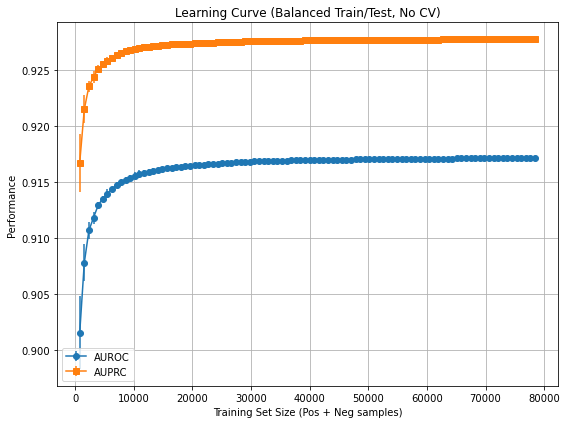

In [49]:
from sklearn.linear_model import LogisticRegression

results_df = custom_learning_curve_balanced_single_df(
    model=LogisticRegression(max_iter=1000),
    data_df=df,  # full dataframe with label_col present
    feature_cols=features,  # your feature columns
    label_col='Same_Complex',
    test_size=0.2,
    train_sizes=np.linspace(0.01, 1.0, 100),
    n_repeats=5,
    outfile_png = "logistic_regression_learning_curve.png"
)

In [43]:
results_df.to_csv('logisitic_regression_learning_curve.csv', index=False)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)

Training sizes: 100%|██████████| 10/10 [08:16<00:00, 49.66s/it]


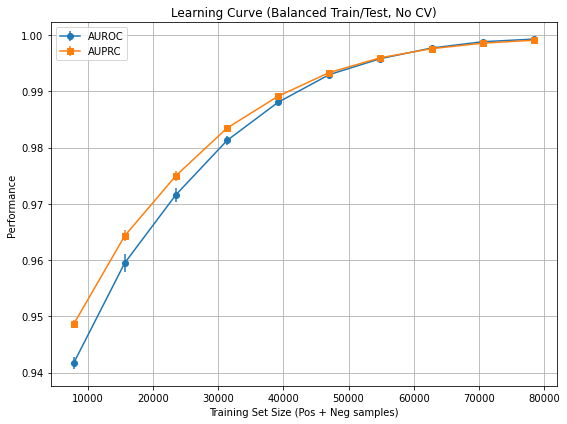

In [52]:
results_rf = custom_learning_curve_balanced_single_df(
    model=rf_model,
    data_df=df,
    feature_cols=features,
    label_col='Same_Complex',
    outfile_png = 'random_forest_learning_curve.png'
)

In [ ]:
results_svm = custom_learning_curve_balanced_single_df(
    model=svm_model,
    data_df=df,
    feature_cols=features,
    label_col='Same_Complex',
    outfile_png = 'svm_learning_curve.png'
)

In [54]:
results_rf.to_csv('random_forest_learning_curve.csv', index=False)

results_svm.to_csv('svm_learning_curve.csv',index=False)

NameError: name 'results_svm' is not defined